In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qmmc import *

## Generate data from a model

Below we define a generative model and use it to sample RFQ outcomes.

In [3]:
# Priors
mu_0, sigma_0 = Value(0), Value(10)
scale_0, shape_0 = Value(3), Value(3)
a_0, b_0 = Value(1), Value(2)
m, n = 5000, 3

# Parameters
mu_V_real = Normal(mu_0, sigma_0, value=0, name='mu_V_real')
sigma_V_real = InvGamma(scale_0, shape_0, value=3, name='sigma_V_real')

mu_Y_real = Normal(mu_0, sigma_0, value=-1, name='mu_Y_real')
sigma_Y_real = InvGamma(scale_0, shape_0, value=3, name='sigma_Y_real')

mu_W_real = Normal(mu_0, sigma_0, value=-0.5, name='mu_W_real')
sigma_W_real = InvGamma(scale_0, shape_0, value=3, name='sigma_W_real')

p_real = Beta(a_0, b_0, value=0.5, name='p_real')

# Variables
k_real = np.empty(m, dtype=object)
V_real = np.empty(m, dtype=object)
W_real = np.empty(m, dtype=object)
Y_real = np.empty(m, dtype=object)
I_real = np.empty(m, dtype=object)
for i in xrange(m):
    k_real[i] = Binomial(p_real, Value(n), name='k_%d_real' % i)
    V_real[i] = Normal(mu_V_real, sigma_V_real, name='V_%d_real' % i)
    W_real[i] = BernoulliNormal(mu_W_real, sigma_W_real, k_real[i], name='W_%d_real' % i)
    Y_real[i] = Normal(mu_Y_real, sigma_Y_real, name='Y_%d_real' % i)
    
    @Function
    def S_i_real(Y=Y_real[i], V=V_real[i], W=W_real[i]):
        
        if len(W) > 0:
            C = np.min(W)
        else:
            C = np.inf
        
        if Y <= np.minimum(C, V): return 2
        if C <= np.minimum(Y, V): return 1
        if V < np.minimum(C, Y): return 0

    I_real[i] = BernoulliFlip(Value(0.0), S_i_real, k=3, name='I_%d_real' % i)

## Estimate model parameters from data

Using the same graphical model - with different initial values for latent variables and parameters- we now use a custom Gibbs sampler to recover the parameters.

In [4]:
# Parameters
mu_V = Normal(mu_0, sigma_0, value=-1, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=5, name='sigma_V')

mu_W = Normal(mu_0, sigma_0, value=1, name='mu_W')
sigma_W = InvGamma(scale_0, shape_0, value=5, name='sigma_W')

p = Beta(a_0, b_0, value=0.2, name='p')

# Variables
k = np.empty(m, dtype=object)
V = np.empty(m, dtype=object)
W = np.empty(m, dtype=object)
Y = np.empty(m, dtype=object)
I = np.empty(m, dtype=object)
for i in xrange(m):
    k[i] = Binomial(p, Value(n), name='k_%d' % i)
    V[i] = Normal(mu_V, sigma_V, name='V_%d' % i)
    W[i] = BernoulliNormal(mu_W, sigma_W, k[i], name='W_%d' % i)
    Y[i] = Value(Y_real[i].value)
    
    @Function
    def S_i(Y=Y[i], V=V[i], W=W[i]):
        
        if len(W) > 0:
            C = np.min(W)
        else:
            C = np.inf
        
        if Y <= np.minimum(C, V): return 2
        if C <= np.minimum(Y, V): return 1
        if V < np.minimum(C, Y): return 0
    
    I[i] = BernoulliFlip(Value(0.0), S_i, k=3, value=I_real[i].value, observed=True, name='I_%d' % i)

In [5]:
all_variables = [mu_V, mu_W, sigma_V, sigma_W]
all_variables.extend(V)
all_variables.extend(W)
all_variables.extend(k)
all_variables.extend([p])

In [6]:
kvw_samplers = np.empty(m, dtype=object)
for i in xrange(m):
    kvw_sampler = KVWSampler(k[i], V[i], W[i], Y[i], I[i])
    kvw_samplers[i] = kvw_sampler
p_sampler = NormalMHSampler(p, scaling=0.01)
all_samplers = list(kvw_samplers).append(p_sampler)

In [7]:
model = Model(variables=all_variables, samplers=kvw_samplers)

In [ ]:
# %%time
model.estimate(100)

0% 

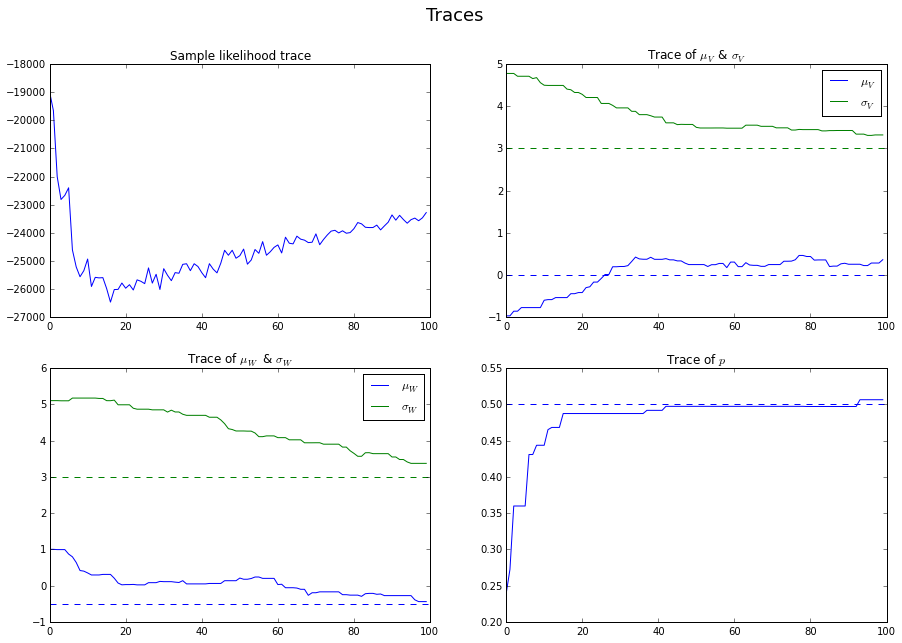

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
# plt.plot(model.logp_hist)
# plt.title("Complete likelihood trace")

plt.plot(model.logp_sample_hist)
plt.title("Sample likelihood trace")

plt.subplot(2, 2, 2)
plt.plot(model.samplers['mu_V'].get_history())
plt.plot(model.samplers['sigma_V'].get_history())
plt.axhline(mu_V_real.value, linestyle='--')
plt.axhline(sigma_V_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
plt.plot(model.samplers['mu_W'].get_history())
plt.plot(model.samplers['sigma_W'].get_history())

plt.axhline(mu_W_real.value, linestyle='--')
plt.axhline(sigma_W_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_W$", r"$\sigma_W$"], loc='best')
plt.title(r"Trace of $\mu_W$ & $\sigma_W$")

plt.subplot(2, 2, 4)
plt.plot(model.samplers['p'].get_history())
plt.axhline(p_real.value, linestyle='--')
plt.title(r"Trace of $p$")

plt.suptitle(r"Traces", size=18)
plt.show()

In [11]:
p.value

0.641451752328154